# Imports

In [1]:
!pip install gensim
!pip install langdetect
!pip install biobert-embedding

import json
import nltk
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import  GridSpec

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram

from nltk import RegexpTokenizer, pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer, WordNetLemmatizer

from langdetect import detect

from biobert_embedding.embedding import BiobertEmbedding

from gensim.models import LdaMulticore
from gensim.corpora import Dictionary

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

     |████████████████████████████████| 983kB 2.6MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=0d8d4ad890a7a8bed07268928ea2b507a740d256fdba14721eb16948a31f479e
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
     |████████████████████████████████| 748.9MB 17kB/s 
     |████████████████████████████████| 133kB 39.1MB/s 
  Created wheel for biobert-embedding: filename=biobert_embedding-0.1.2-cp36-none-any.whl size=5702 sha256=81432322d4dc5978c56dbb0e9eda59d678e459d261fa0bdb0cea6a7638ef4f32
  Stored in directory: /root/.cache/pip/wheels/ad/15/65/3fc6192a7cb7920672bb46d566173decb0875f35bbe03cd09d
Successfully built biobert-embedding
ERROR: torchvision 0.6.0+cu101 has requirement torch==1.5.0, but you'll have torch 1.2.0 which is incompatible.
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully unin

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
%cd /content/drive/My Drive/NLP/Project
%ls

/content/drive/My Drive/NLP/Project
 app.log
 array.csv
'Average knn distance.png'
 biobert_v1.1_pubmed_pytorch_model/
'Choice of k.png'
 dict.json
 Exemples/
'First eps search for DBSCAN.png'
'Hierarchical clustering - average linkage.png'
'Hierarchical clustering.png'
'Hierarchical clustering - ward linkage.png'
 improved_cluster_tsne.png
 information_extraction_colab.ipynb
 information_extraction.ipynb
 IRTM_Proposal.pdf
 metadata.csv
 noncomm_use_subset/
 Ressources/
'Screenshot 2020-04-15 at 20.56.34.png'
'Screenshot 2020-04-15 at 22.41.45 (2).png'
'Screenshot 2020-04-15 at 22.54.48 (2).png'
'Silhouette & Davies index for KNN.png'
 t-sne_covid19.png
 t-SV.png
 tulkens2019.pdf


# Preprocessing

In [3]:
df = pd.read_csv('metadata.csv')
df_concat = pd.concat([df['title'], df['abstract']], axis=1)
print(df.shape)
print(df_concat.shape)

(51078, 18)
(51078, 2)


In [4]:
df = df_concat.dropna()
print(df.shape)

(42203, 2)


In [5]:
text_list = list()
for i in df.index:
  text_list.append(df['title'][i] +' '+ df['abstract'][i])
df['text'] = text_list
print(df.shape)

(42203, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [6]:
first_text = df['text'][0]
print(first_text)

Airborne rhinovirus detection and effect of ultraviolet irradiation on detection by a semi-nested RT-PCR assay BACKGROUND: Rhinovirus, the most common cause of upper respiratory tract infections, has been implicated in asthma exacerbations and possibly asthma deaths. Although the method of transmission of rhinoviruses is disputed, several studies have demonstrated that aerosol transmission is a likely method of transmission among adults. As a first step in studies of possible airborne rhinovirus transmission, we developed methods to detect aerosolized rhinovirus by extending existing technology for detecting infectious agents in nasal specimens. METHODS: We aerosolized rhinovirus in a small aerosol chamber. Experiments were conducted with decreasing concentrations of rhinovirus. To determine the effect of UV irradiation on detection of rhinoviral aerosols, we also conducted experiments in which we exposed aerosols to a UV dose of 684 mJ/m(2). Aerosols were collected on Teflon filters a

In [7]:
df = df.drop(labels=['title', 'abstract'], axis=1)
print(df.shape)

(42203, 1)


In [8]:
### CHECKPOINT ###
df_copy = df
df.head()

,text
0,Airborne rhinovirus detection and effect of ul...
1,Discovering human history from stomach bacteri...
2,A new recruit for the army of the men of death...
3,Association of HLA class I with severe acute r...
4,A double epidemic model for the SARS propagati...


In [9]:
df.shape

(42203, 1)

In [10]:
df.head()

,text
0,Airborne rhinovirus detection and effect of ul...
1,Discovering human history from stomach bacteri...
2,A new recruit for the army of the men of death...
3,Association of HLA class I with severe acute r...
4,A double epidemic model for the SARS propagati...


In [11]:
language = []
n_words = []
it_counter=0

for index in df.index:

    # progress trackerd
    it_counter+=1
    progress = it_counter/round(len(df.index)/100,0)
    if progress%10==0:
      print('[INFO] progress:', int(progress), '%')

    # count words
    n_words.append(len(word_tokenize(df['text'][index])))

    # detect language
    try:
        language.append(detect(df['text'][index]))
    except:
        language.append('error')

df['language']=language
df['n_words']=n_words

[INFO] progress: 10 %
[INFO] progress: 20 %
[INFO] progress: 30 %
[INFO] progress: 40 %
[INFO] progress: 50 %
[INFO] progress: 60 %
[INFO] progress: 70 %
[INFO] progress: 80 %
[INFO] progress: 90 %
[INFO] progress: 100 %


In [12]:
### CHECKPOINT ###
df_copy = df
#df=df_copy
print(df.shape)

(42203, 3)


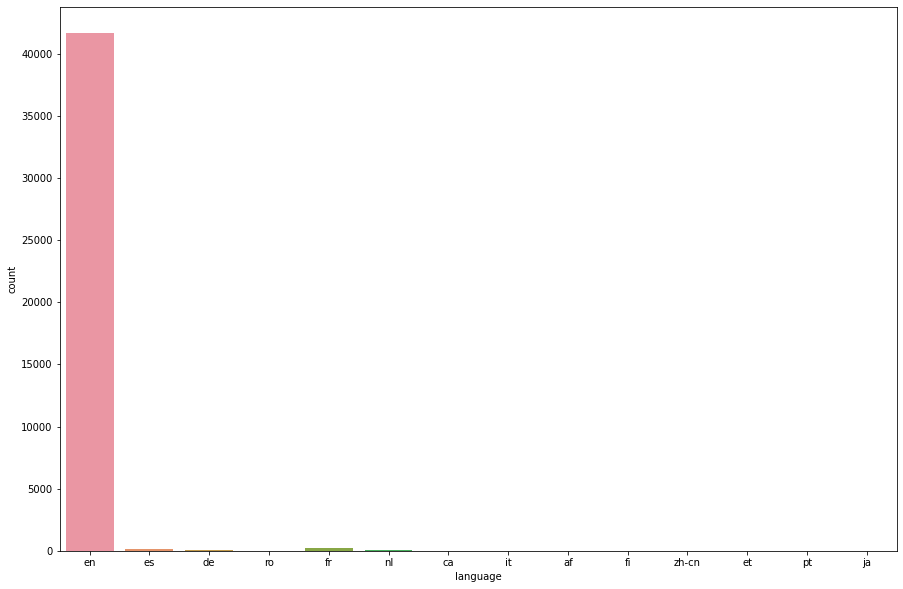

In [13]:
plt.figure(figsize=(15,10))
sns.countplot(df.language)

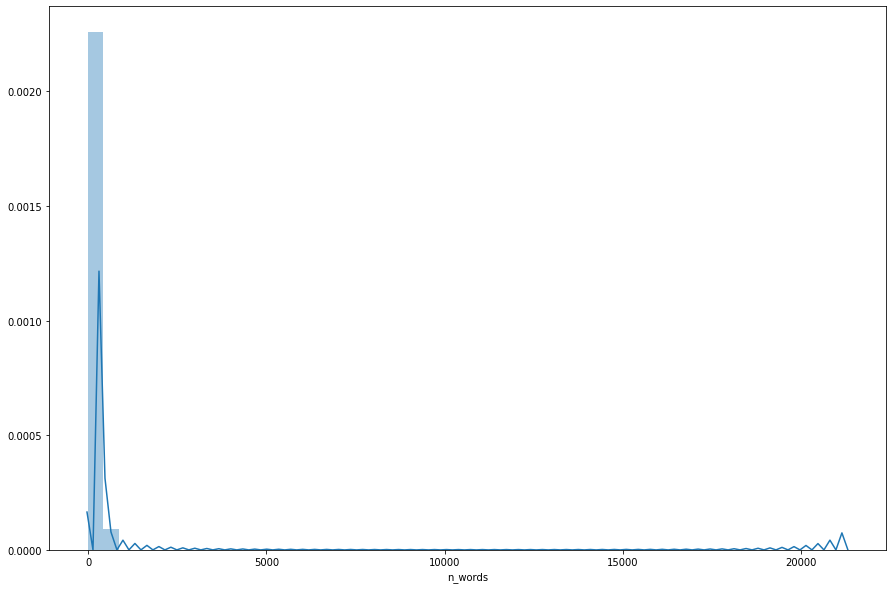

In [14]:
plt.figure(figsize=(15,10))
sns.distplot(df.n_words)

In [15]:
df.n_words.describe()

count    42203.000000
mean       238.790702
std        163.972823
min          2.000000
25%        170.000000
50%        233.000000
75%        298.000000
max      21284.000000
Name: n_words, dtype: float64

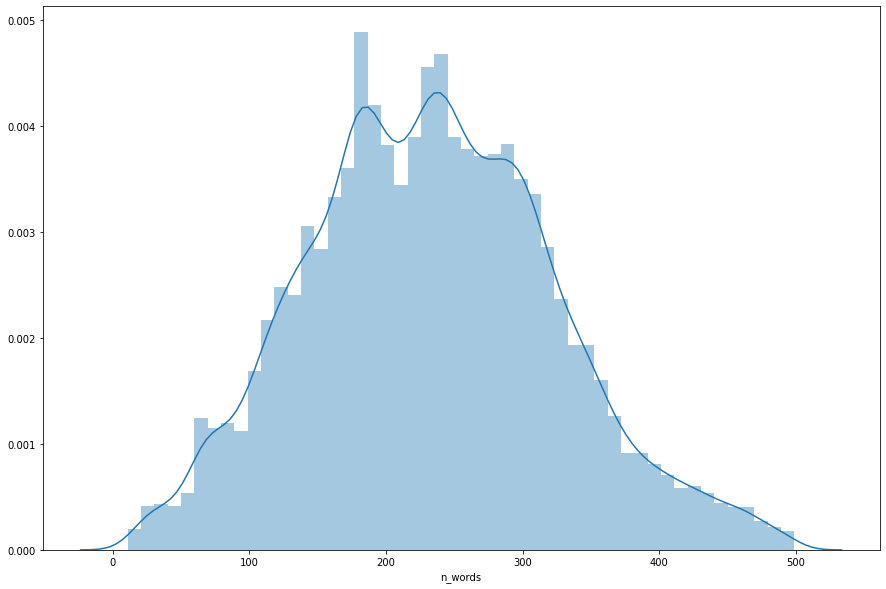

In [16]:
df = df[df.n_words<500]
df = df[df.n_words>10]
df = df[df.language=='en']
plt.figure(figsize=(15,10))
sns.distplot(df.n_words)

In [17]:
df = df.drop(['language', 'n_words'], axis=1)
#df = df.sample(n=10000)
df.shape

(41130, 1)

# Latent Semantic Analysis


LSA is the traditional method for topic modeling. The technique ignore the syntax and semantics such as word order, meaning and grammar. It just treat every document as a bag of words.

To compute the frequency of each words, we use TF-IDF. This will give us a vectorized representation of each documents. 

see (paper) : https://arxiv.org/pdf/1410.6991.pdf

see (paper) : http://zke.fas.harvard.edu/papers/TSCORE-arXiv-v2.pdf

In [0]:
### CHECKPOINT ###
df_copy = df
#df = df_copy

In [19]:
lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
it_counter=0
token_dictionary = {}

# set of words qualified a posteriori as undesirable in the corpus
undesirable=['abstract', 'virus', 'covid19', 'coronavirus', 'used', 'using', 'abstract', 'virus']

for i in df.index:

    document_unit = df['text'][i]

    # progress tracker
    it_counter+=1
    progress = it_counter/round(len(df.index)/100,0)
    if progress%10==0:
        print('[INFO] progress:', int(progress), '%')


    # normalization : delete hyphens & case folding : lower case)
    liste=[]
    for c in document_unit:
        if c!= '-':
            liste.append(c.lower())
    normalized_document_unit = ''.join(liste)

    # tokenization, get only words (no numbers)
    tokenizer = RegexpTokenizer('[a-zA-Z_]+')
    tokens = tokenizer.tokenize(normalized_document_unit)

    # delete undesirable words
    for u in undesirable:
        try:
            tokens.remove(u)
        except:
            pass

    # remove english stop words
    filteredtokens = [w for w in tokens if not w in stop_words]

    # stemmatization, lemmatization
    result = []
    for word in filteredtokens:
        if len(word)>2:
            lem = lemmatizer.lemmatize(word)
            #stem = porter_stemmer.stem(lem)
            result.append(lem)

    token_dictionary[i] = result
    df['text'][i] = ' '.join(result)

[INFO] progress: 10 %
[INFO] progress: 20 %
[INFO] progress: 30 %
[INFO] progress: 40 %
[INFO] progress: 50 %
[INFO] progress: 60 %
[INFO] progress: 70 %
[INFO] progress: 80 %
[INFO] progress: 90 %
[INFO] progress: 100 %


In [20]:
df['text'][0]

'airborne rhinovirus detection effect ultraviolet irradiation detection seminested rtpcr assay background rhinovirus common cause upper respiratory tract infection implicated asthma exacerbation possibly asthma death although method transmission rhinovirus disputed several study demonstrated aerosol transmission likely method transmission among adult first step study possible airborne rhinovirus transmission developed method detect aerosolized rhinovirus extending existing technology detecting infectious agent nasal specimen method aerosolized rhinovirus small aerosol chamber experiment conducted decreasing concentration rhinovirus determine effect irradiation detection rhinoviral aerosol also conducted experiment exposed aerosol dose aerosol collected teflon filter rhinovirus recovered qiagen avl buffer qiagen qiaamp viral rna kit qiagen corp valencia california followed seminested rtpcr detection gel electrophoresis result obtained positive result filter sample collected least tcid a

In [21]:
vectorizer = TfidfVectorizer(
    # if different encoding
    decode_error='ignore',
    # remove accent
    strip_accents='ascii',
    # analyse at the word level
    analyzer='word',
    # remove stopwords just to make sure they are gone
    stop_words='english',
    # token pattern
    token_pattern='\w{3,20}',
    # number of features
    max_features=30,
    # normalize the tf-idf to make the vector have a unit norm = cosine normalization
    norm='l2',
    # use sublinear tf
    sublinear_tf=True,
    # to enable inverse-document-frequency reweighting
    use_idf=True,
    # smoothing to prevent zero division
    smooth_idf=True
)
embedding = vectorizer.fit_transform(df['text'])
embedding_arr = embedding.toarray()
feature_names = vectorizer.get_feature_names()

print(feature_names)

['acute', 'analysis', 'antibody', 'case', 'cell', 'clinical', 'control', 'data', 'disease', 'gene', 'health', 'host', 'human', 'infection', 'infectious', 'influenza', 'method', 'model', 'mouse', 'patient', 'protein', 'respiratory', 'response', 'result', 'rna', 'strain', 'study', 'vaccine', 'viral', 'virus']


In [22]:
embedding_arr.shape

(41130, 30)

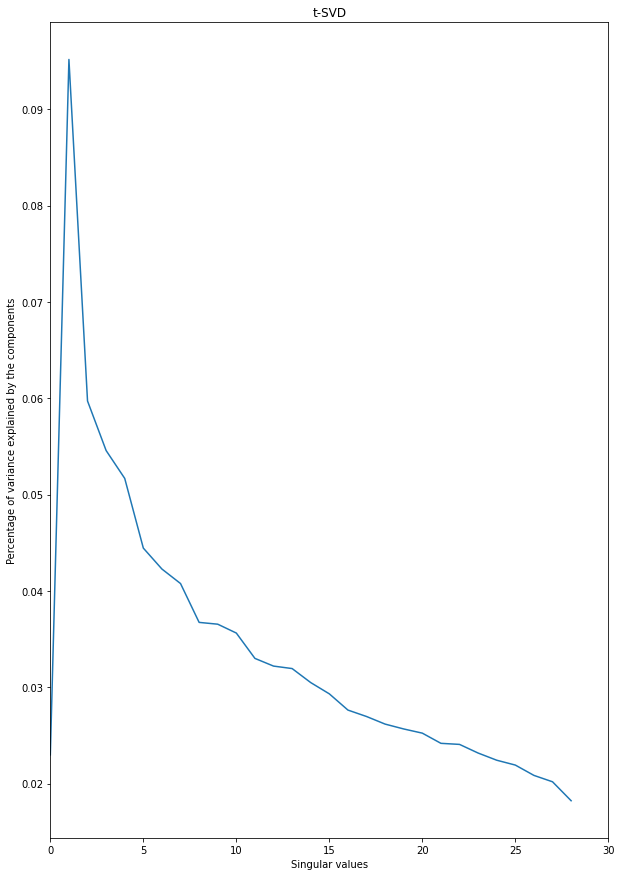

In [23]:
tsvd = TruncatedSVD(n_components=29)
tsvd.fit_transform(embedding_arr)
plt.figure(figsize=(10, 15))
plt.xlim((0, 30))
plt.title('t-SVD')
plt.xlabel('Singular values')
plt.ylabel('Percentage of variance explained by the components')
plt.savefig('t-SV.png')
plt.plot(tsvd.explained_variance_ratio_)
plt.show()
# embedding.shape

SVD is about finding the best projection to project our data. The best means we want to make sure the reconstruction error is minimized. To make the dimensionality reduction, the trick is to put some of the singular values to zero. If you keep 2 SV, you will project to 2 dimensions. The Frobenius norm represent the squared difference between the old 
matrix and the reconstruction.
if A = U.S.M (U=user-to-concept, S=SV, M=movies-to-concept)

U.S will then give the coordinate of the users on the different axis.

see : https://www.youtube.com/watch?v=UyAfmAZU_WI

Wen you plot the entropy as a function of k, different dimensions lead to different graphs. As we want to locate the elbow of the graph, lets see what is the optimal number of dimension according to the graph...

see : https://monkeylearn.com/topic-analysis/


In [24]:
tsvd = TruncatedSVD(n_components=4)
embedding_reduced = tsvd.fit_transform(embedding_arr)
embedding_reduced.shape

(41130, 4)

In [25]:
tsvd.singular_values_

array([91.26889888, 56.01405926, 44.54765889, 42.36544755])

In [26]:
X = pd.DataFrame(embedding_reduced)
X.describe()

,0,1,2,3
count,4.113000e+04,41130.000000,41130.000000,41130.000000
mean,4.291282e-01,-0.014822,-0.022830,0.006589
std,1.355664e-01,0.275802,0.218470,0.208796
min,-2.289320e-18,-0.640210,-0.610237,-0.608911
25%,3.448674e-01,-0.248970,-0.174702,-0.146467
50%,4.364801e-01,-0.020899,-0.032103,-0.000000
75%,5.255208e-01,0.208586,0.122692,0.155096
max,8.132264e-01,0.655698,0.659476,0.621857


In [27]:
X.head()

,0,1,2,3
0,5.498331e-01,-8.876314e-02,1.113082e-01,4.054630e-02
1,2.734690e-01,5.096519e-02,-8.098601e-02,-9.742187e-02
2,-2.289320e-18,-4.339518e-16,1.204659e-15,5.844219e-16
3,6.100208e-01,-5.800150e-01,2.009964e-02,1.719229e-01
4,4.757959e-01,-3.110488e-01,-7.452787e-02,1.032085e-01


In [0]:
scaled_embedding_reduced = embedding_reduced

In [0]:
np.savetxt(
  fname='array.csv',
  X=scaled_embedding_reduced,
  fmt='%.18e', 
  delimiter=','
)

# Clustering

## Partitioning based: KNN

In [0]:
# Copy data from dimensionality reduction section
X = scaled_embedding_reduced

[0.2768132954837461, 0.2928152927354001, 0.2808544707534212, 0.27299503571430916, 0.2645747101196861, 0.24923492149488266, 0.24221848940612764, 0.23907605496118003, 0.24326923168470246, 0.23870023411746374]
[1.4135520659153098, 1.2751355995880367, 1.1685841242463326, 1.1574900071320156, 1.1591124147835645, 1.21202829182532, 1.2314851711679262, 1.2234937833072328, 1.1832930307757712, 1.1753018703026668]


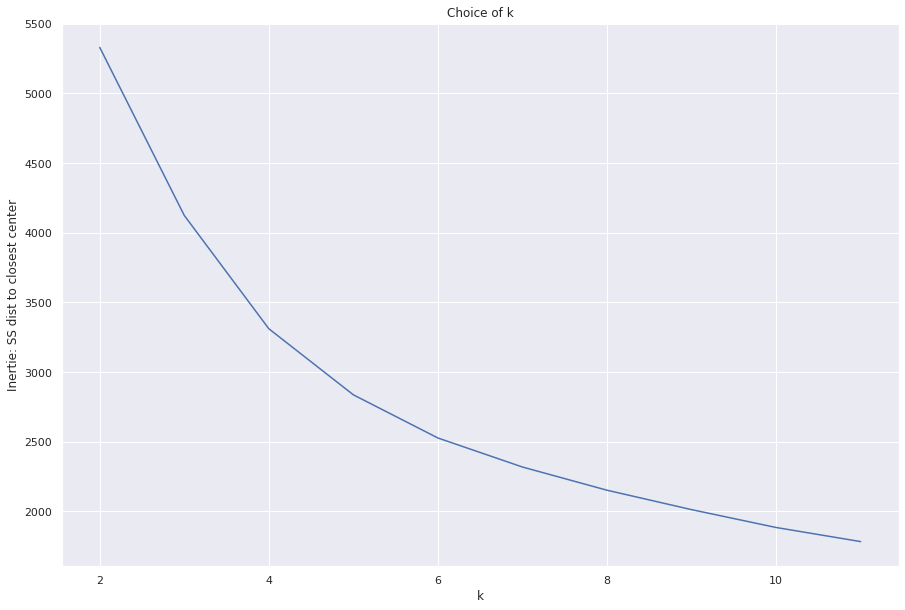

<Figure size 360x576 with 0 Axes>

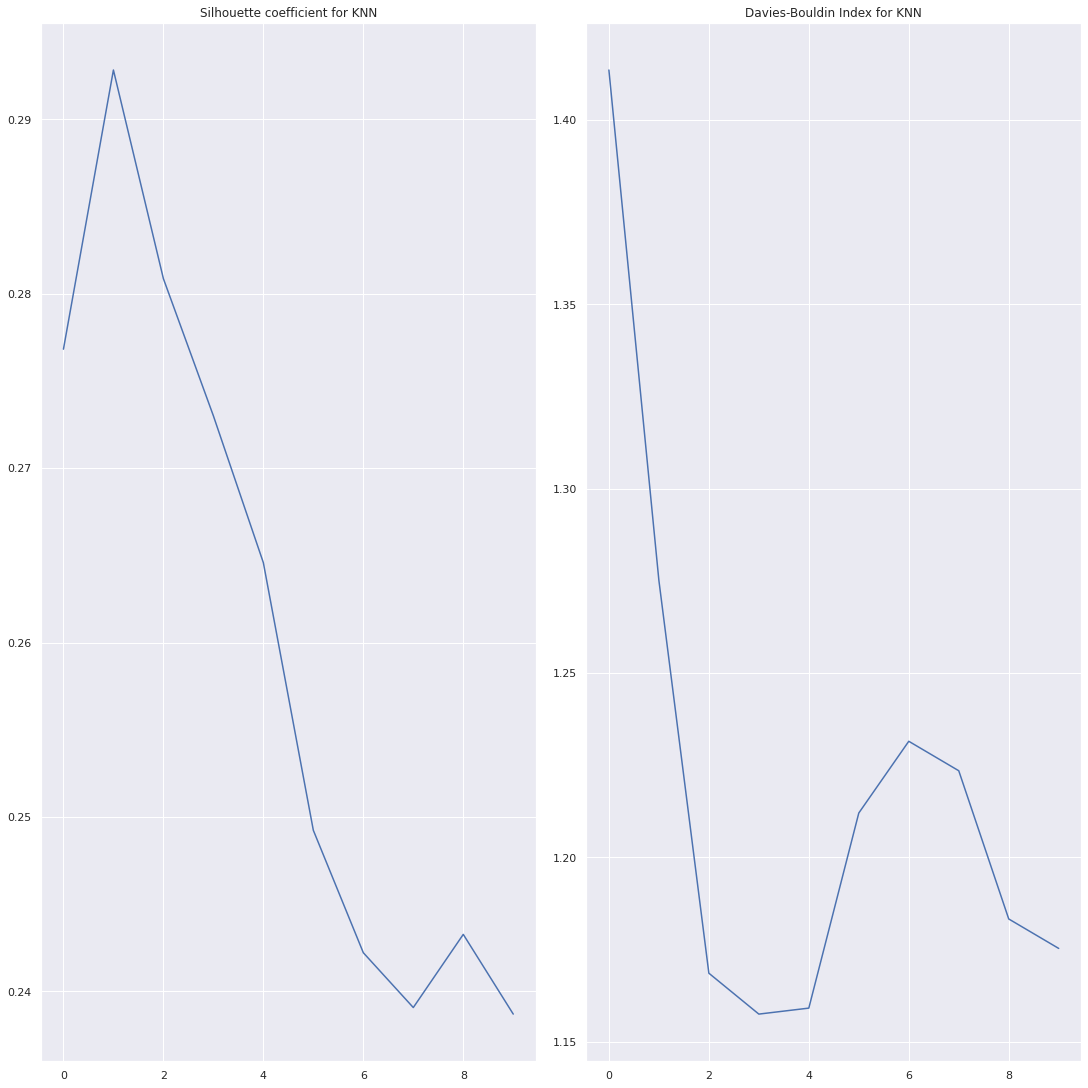

In [50]:
# run kmeans with many different k
inertie = []
sil = []
dav = []

k_set = range(2, 12)

for k in k_set:
    km = KMeans(
        n_clusters=k, 
        algorithm='elkan',
        init='k-means++',
        n_init=10   
    )
    l = km.fit_predict(X)
    inertie.append(km.inertia_)
    sil.append(silhouette_score(X, l))
    dav.append(davies_bouldin_score(X, l))

print(sil)
print(dav)

plt.figure(figsize=(15, 10))
plt.title('Choice of k')
plt.xlabel('k')
plt.ylabel('Inertie: SS dist to closest center')
plt.plot(k_set, inertie)
plt.savefig('Choice of k.png')
plt.show()

plt.figure(figsize=(5, 8))
fig = plt.figure(constrained_layout=True)
spec = GridSpec(ncols=2, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax1.set_title('Silhouette coefficient for KNN')
ax1.plot(sil)
ax2 = fig.add_subplot(spec[0, 1])
ax2.set_title('Davies-Bouldin Index for KNN')
ax2.plot(dav)
plt.savefig('Silhouette & Davies index for KNN.png')
plt.show()

In [0]:
k = 4
km = KMeans(
    n_clusters=k,
    init='k-means++',
    n_init=30,
    verbose=1,
    algorithm='elkan'
)
l = km.fit_predict(X)

In [0]:
def plot2D(k, X, l):
  sns.set(rc={'figure.figsize':(15,15)})
  palette = sns.hls_palette(n_colors=k, l=.4, s=.9)
  p = 100

  print('\n =============== Summary with perplexity :',p,'===============')
  tsne = TSNE(verbose=1, perplexity=p, random_state=42)
  proj = tsne.fit_transform(X)
  sns.scatterplot(proj[:,0], proj[:,1], hue=l, legend='full', palette=palette)
  plt.show()

t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. 
- start with the original scatterplot, determine the similarity between each points using a Gaussian distribution (with variance proportional to the density of the cluster), and then scale to add up to one. Also, the similarity is averaged in both direction (as s(a,b)!=s(b,a) )
- randomly project them on a 1 dimensional space
- move points one at the time to find the cluster back, at each steps, a point on the line is attracted by point it is near to in the original scatterplot, and repelled by points it is far from in the 1 dimensional line (similarity in the number line is based on a t-distribution, hence the name, and it is scaled for the same reasons as above)...

see : https://www.youtube.com/watch?v=NEaUSP4YerM


Perplexity really should be smaller than the number of points. 

The t-SNE algorithm adapts its notion of “distance” to regional density variations in the data set. As a result, it naturally expands dense clusters, and contracts sparse ones.  Result : you cannot see relative sizes of clusters in a t-SNE plot.

The distances between well-separated clusters in a t-SNE plot may mean nothing.

A classic pitfall is thinking you see patterns in what is really just random data. Recognizing noise when you see it is a critical skill, but it takes time to build up the right intuitions. A tricky thing about t-SNE is that it throws a lot of existing intuition out the window. Low perplexity values often lead to this kind of distribution (clumps in random noize). --> we should keep the perplexity pretty high.

More accurate than what any linear project can produce !



see : https://distill.pub/2016/misread-tsne/

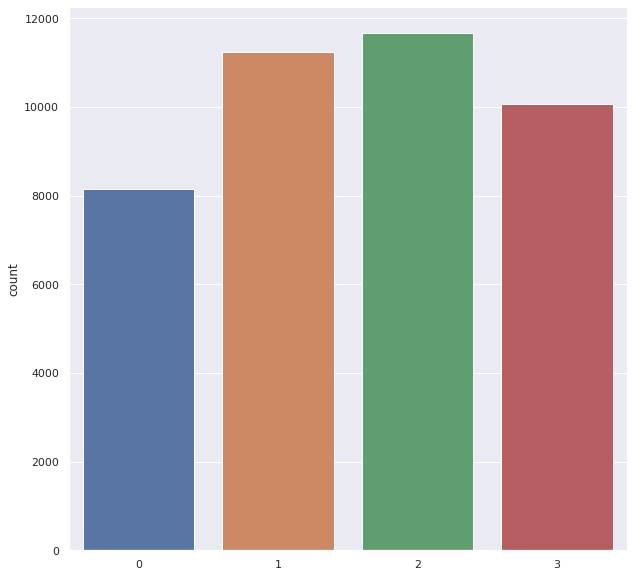

In [43]:
df['l'] = l
plt.figure(figsize=(10, 10))
sns.countplot(l)
plt.show()


 =============== Summary with perplexity : 100 ===============
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 41130 samples in 0.032s...
[t-SNE] Computed neighbors for 41130 samples in 4.837s...
[t-SNE] Computed conditional probabilities for sample 1000 / 41130
[t-SNE] Computed conditional probabilities for sample 2000 / 41130
[t-SNE] Computed conditional probabilities for sample 3000 / 41130
[t-SNE] Computed conditional probabilities for sample 4000 / 41130
[t-SNE] Computed conditional probabilities for sample 5000 / 41130
[t-SNE] Computed conditional probabilities for sample 6000 / 41130
[t-SNE] Computed conditional probabilities for sample 7000 / 41130
[t-SNE] Computed conditional probabilities for sample 8000 / 41130
[t-SNE] Computed conditional probabilities for sample 9000 / 41130
[t-SNE] Computed conditional probabilities for sample 10000 / 41130
[t-SNE] Computed conditional probabilities for sample 11000 / 41130
[t-SNE] Computed conditional probabilities for sample

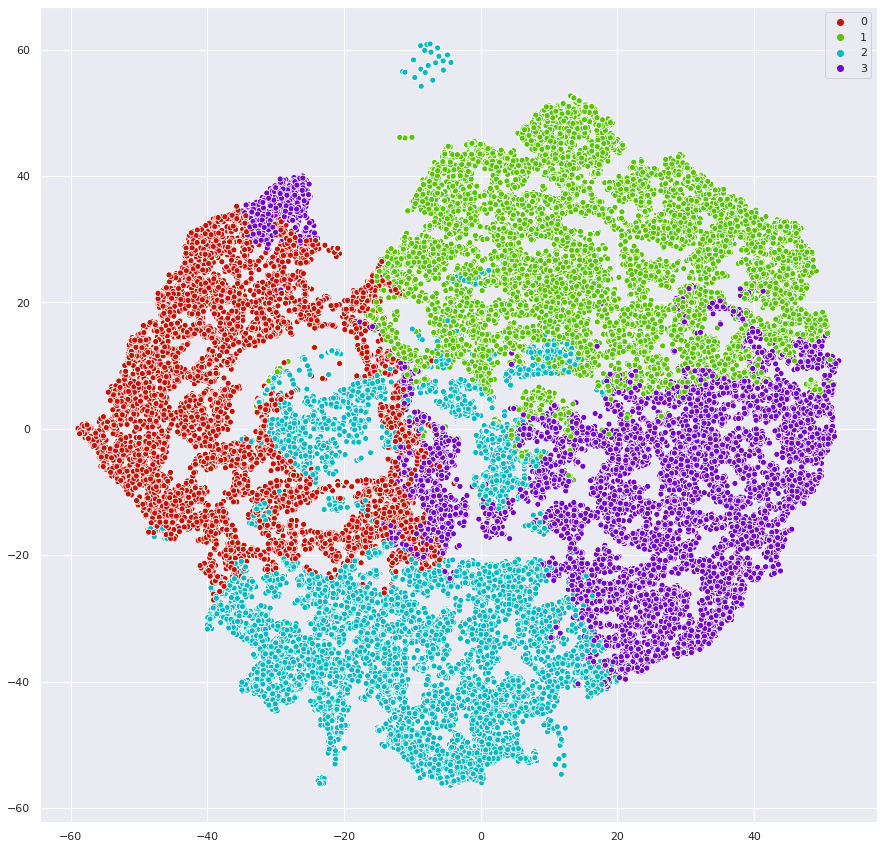

In [44]:
plot2D(k, X, l)

## Density based: DBSCAN


The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. Sensitive to the parameters eps (maximum radius of the neightborhood) and min_samples (min number of points in the eps neightborhood necessary to define a core point). 

see: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

In [0]:
# copy data from the dimensionality reduction section
X = scaled_embedding_reduced

In order to have a clue for the range of eps, lets run an unsupervised learner that implement neighbor search (NearestNeighbors). We can calculate the distance from each point to its closest neighbour using the NearestNeighbors. The point itself is included in n_neighbors. The kneighbors method returns two arrays, one which contains the distance to the closest n_neighbors points and the other which contains the index for each of those points.

--> The optimal value for epsilon will be found at the point of maximum curvature.

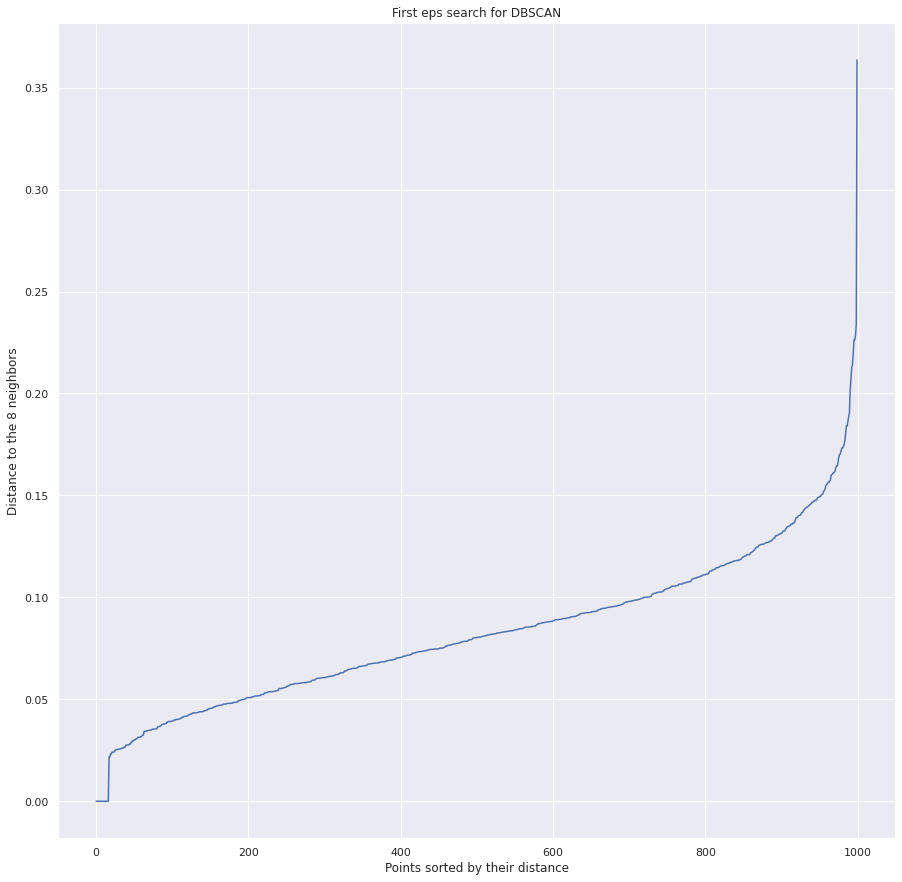

In [0]:
# find an optimal eps
nn = NearestNeighbors(n_neighbors=k)
nbrs = nn.fit(X)
distances, indices = nn.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.title('First eps search for DBSCAN')
plt.xlabel('Points sorted by their distance')
plt.ylabel('Distance to the 8 neighbors')
plt.savefig('First eps search for DBSCAN.png')
plt.plot(distances)

From this graph we can guess that the eps value should lie between 0.10 and 0.15

In [0]:
eps = 0.13

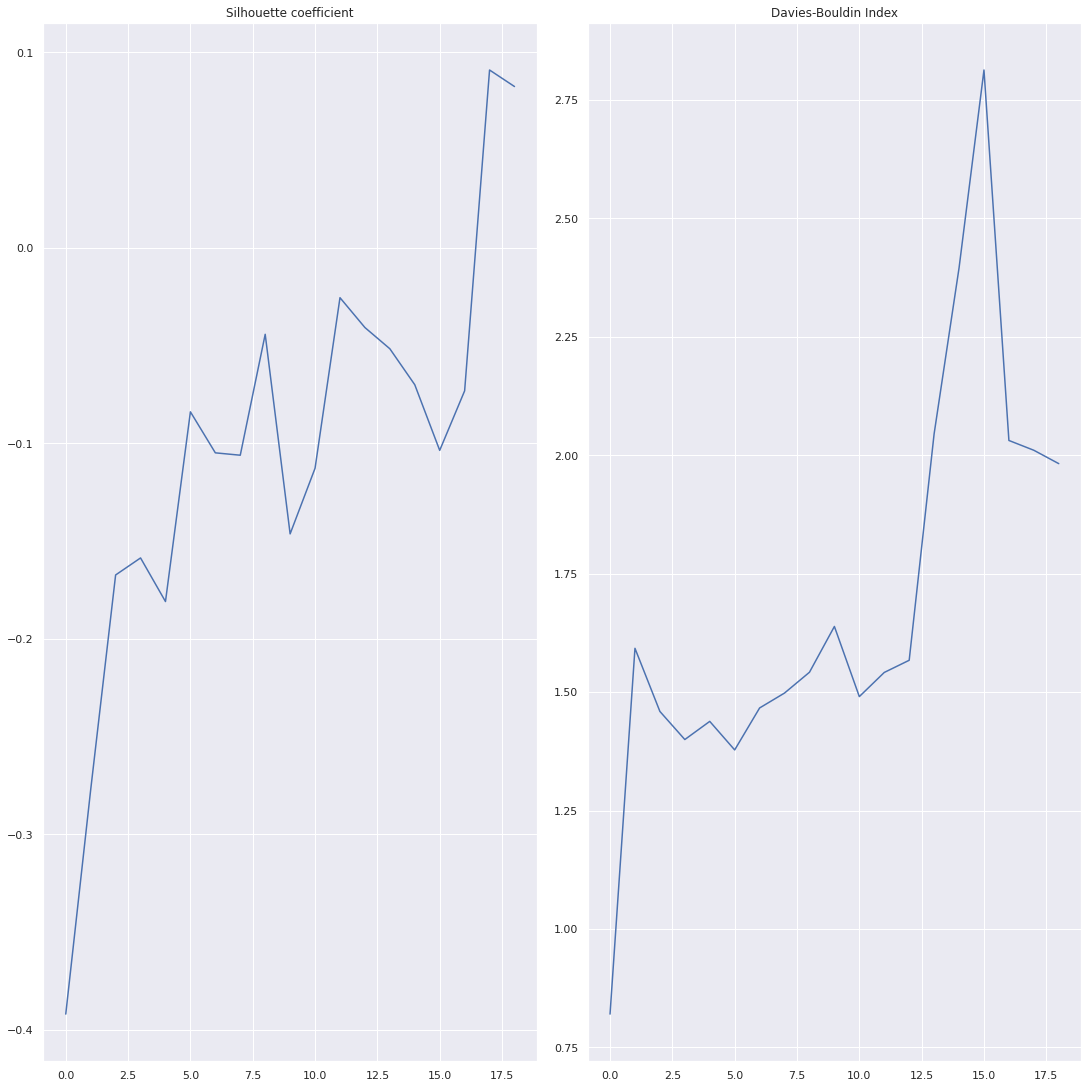

In [0]:
# search of n_samples: we know eps is [0.12-0.15]
sil = []
dav = []
samples = range(1,20)

for s in samples:
  db = DBSCAN(eps=eps, min_samples=s).fit(X)
  l = db.labels_
  sil.append(silhouette_score(X, l))
  dav.append(davies_bouldin_score(X, l))

fig = plt.figure(constrained_layout=True)
spec = GridSpec(ncols=2, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax1.set_title('Silhouette coefficient')
ax1.plot(sil)
ax2 = fig.add_subplot(spec[0, 1])
ax2.set_title('Davies-Bouldin Index')
ax2.plot(dav)
plt.show()

From this search 

- at 3 there is a small decrease in Devies index which correspond to a reasonably high Silhouette coefficient 

- at 14 there is a local minima in Devies index which correspond to a relatively high Silouhette coefficient.

3 should be a good tradoff between the two values (and insured to classify in more than two big classes.

In [0]:
opt_sample = 5

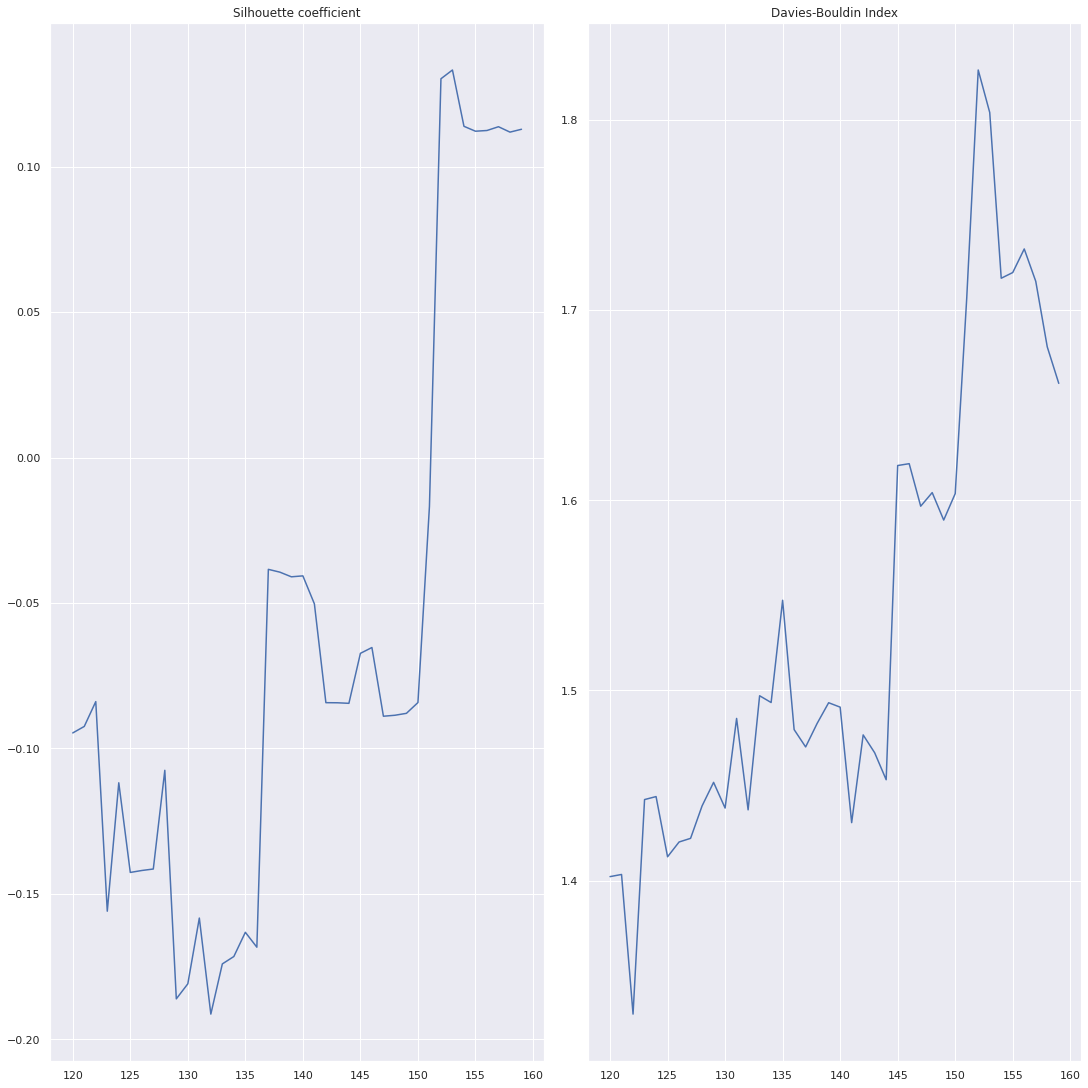

In [0]:
# search of n_samples
sil = []
dav = []
epsilons = range(120,160)

for e in epsilons:
  e = e/1000
  db = DBSCAN(eps=e, min_samples=opt_sample).fit(X)
  l = db.labels_
  sil.append(silhouette_score(X, l))
  dav.append(davies_bouldin_score(X, l))

fig = plt.figure(constrained_layout=True)
spec = GridSpec(ncols=2, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax1.set_title('Silhouette coefficient')
ax1.plot(epsilons, sil)
ax2 = fig.add_subplot(spec[0, 1])
ax2.set_title('Davies-Bouldin Index')
ax2.plot(epsilons, dav)
plt.show()

Given the variability of the graphs I prefer to analyse this in two parts

This graph is quite interesting... We see two areas of interest:

- before 0.16, we should consider


In [0]:
opt_eps = 0.137

If the ground truth label is not known, there is potentially two complementary metrics : Silhouette coefficient and Davies-Bouldin Index

- The Silhouette Coefficient is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

- the Davies-Bouldin index can be used to evaluate the model, where a lower Davies-Bouldin index relates to a model with better separation between the clusters.This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. Zero is the lowest possible score. Values closer to zero indicate a better partition.

see : https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

In [0]:
 # Final DBSCAN
db = DBSCAN(eps=opt_eps, min_samples=opt_sample).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
l = db.labels_

In [0]:
# Number of clusters in labels, ignoring noise if present
k = len(set(l)) - (1 if -1 in l else 0)
noise = list(l).count(-1)

In [0]:
print('Estimated number of clusters: %d' % k)
print('Estimated number of noise points: %d' % noise)
print("Silhouette Coefficient: %0.3f"% silhouette_score(X, l))

Estimated number of clusters: 7
Estimated number of noise points: 178
Silhouette Coefficient: -0.038


In [0]:
# remove outliers
print(X.shape)
print(l.shape)

X_df = pd.DataFrame(X)
X_df['l']=l
X_df = X_df[X_df.l !=-1]
X = np.array(X_df.drop(columns='l'))
l = np.array(X_df.l)
print(X.shape)
print(l.shape)

(1000, 5)
(1000,)
(822, 5)
(822,)


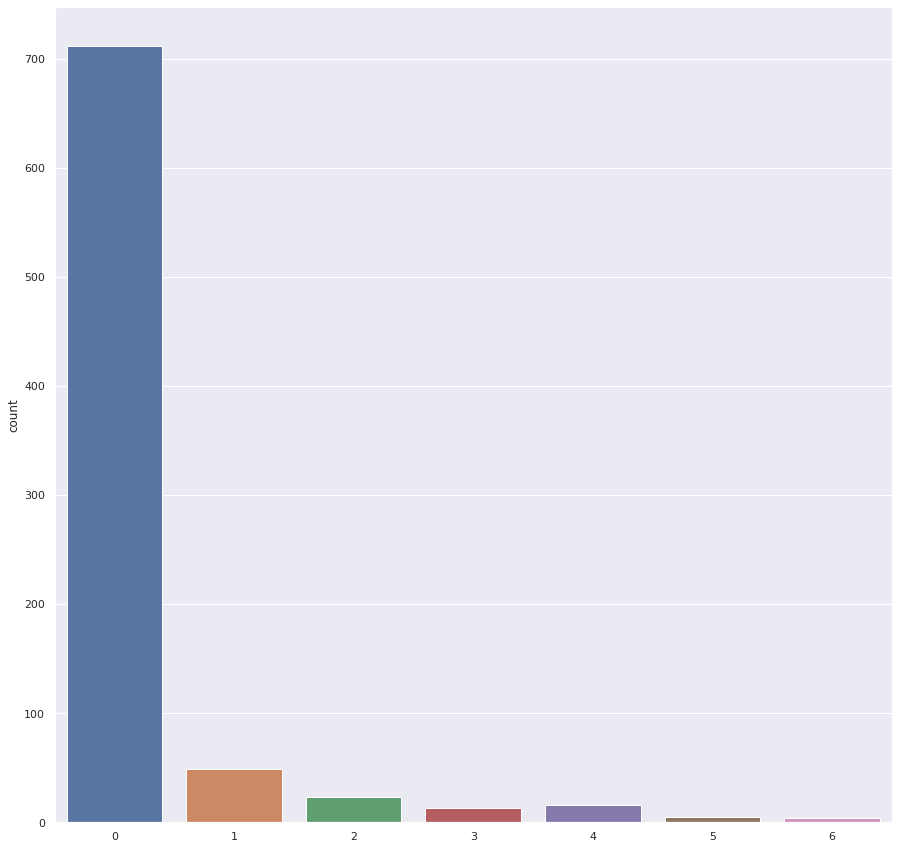

In [0]:
sns.countplot(l)


 =============== Summary with perplexity : 100 ===============
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 822 samples in 0.002s...
[t-SNE] Computed neighbors for 822 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 822 / 822
[t-SNE] Mean sigma: 0.142095
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.685371
[t-SNE] KL divergence after 1000 iterations: 0.486999


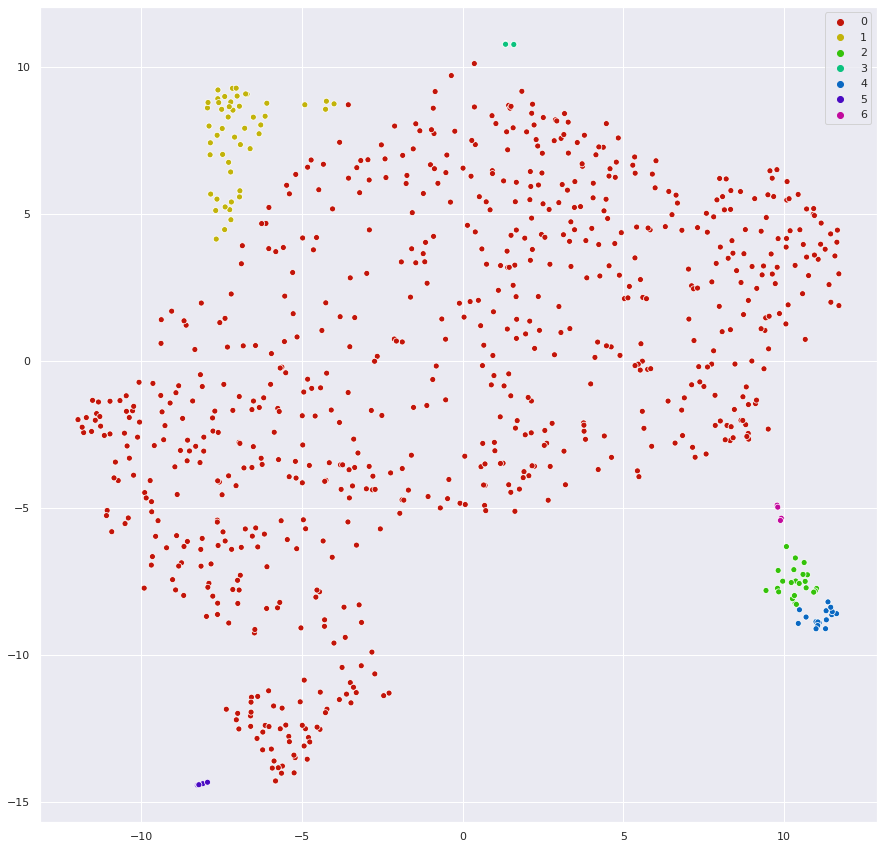


 =============== Summary with perplexity : 150 ===============
[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 822 samples in 0.000s...
[t-SNE] Computed neighbors for 822 samples in 0.145s...
[t-SNE] Computed conditional probabilities for sample 822 / 822
[t-SNE] Mean sigma: 0.167079
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.810272
[t-SNE] KL divergence after 750 iterations: 0.443548


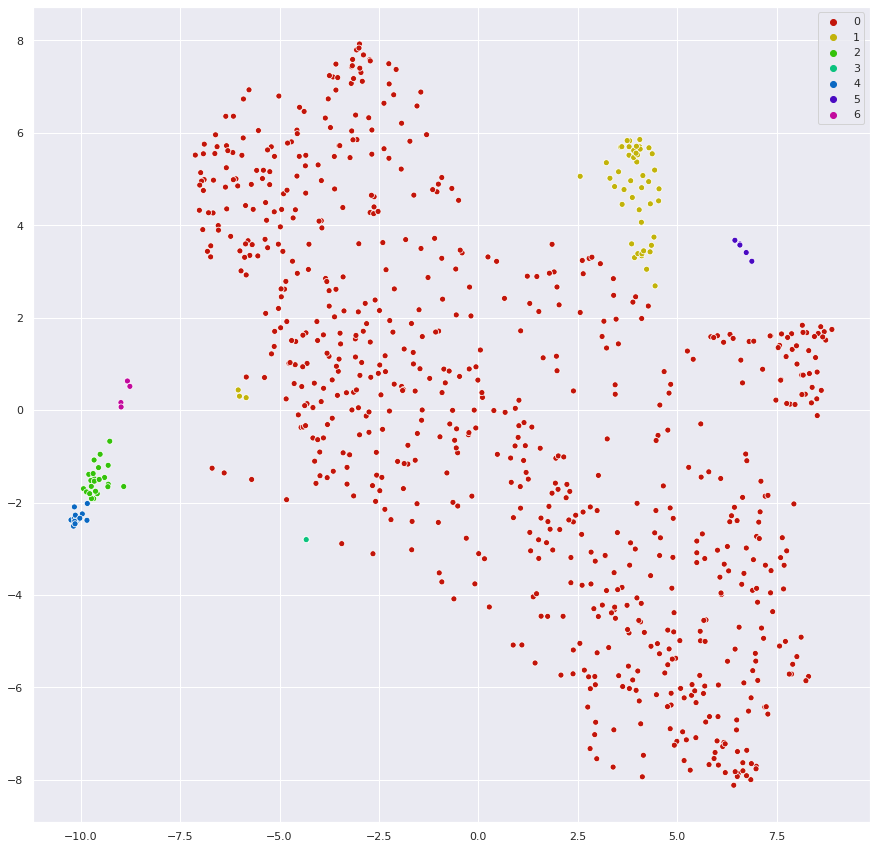


 =============== Summary with perplexity : 200 ===============
[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 822 samples in 0.000s...
[t-SNE] Computed neighbors for 822 samples in 0.126s...
[t-SNE] Computed conditional probabilities for sample 822 / 822
[t-SNE] Mean sigma: 0.189837
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.420631
[t-SNE] KL divergence after 1000 iterations: 0.341509


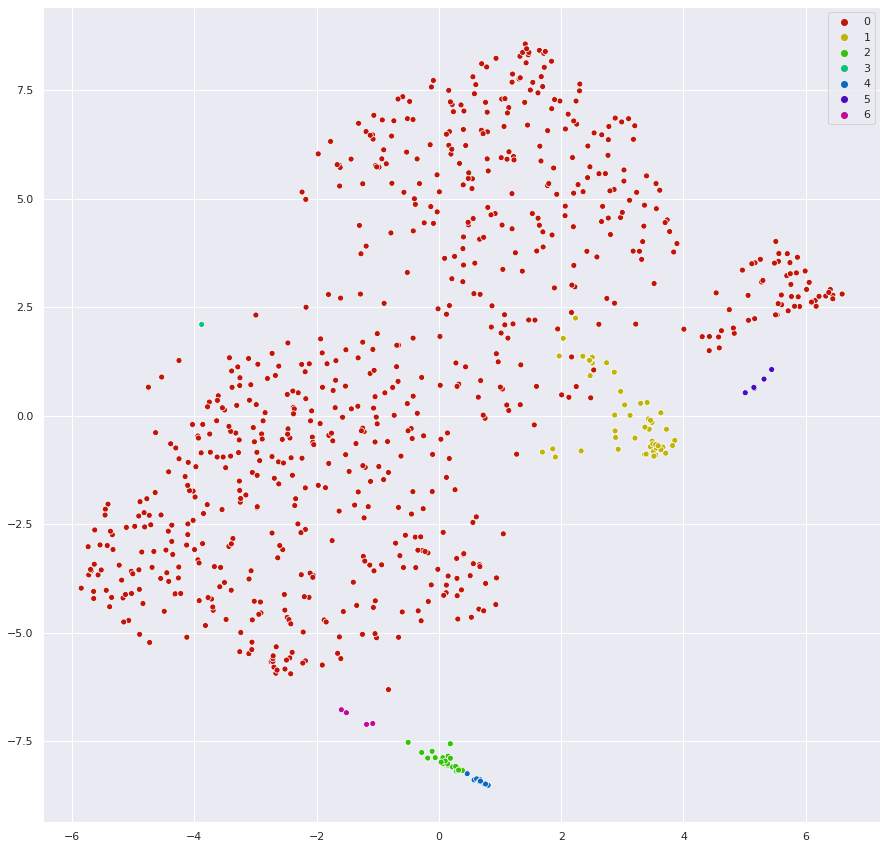

In [0]:
plot2D(7, X, l)

## Hierarchical: Agglomerative clustering

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample. See the Wikipedia page for more details.

Using connectivity constrain make sense here as we will need a fast algorithm give the amount of data. This imply that single and complete linkage should be avoided. The connectivity constraint state that the algorythm can only merge adjacent cluster together. It can help to unroll manifolds.

see : https://scikit-learn.org/stable/modules/clustering.html

In [0]:
X = scaled_embedding_reduced

In [0]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [0]:
graph = kneighbors_graph(
    X=X,
    n_neighbors=2, 
    mode='connectivity',
)

### Ward

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_agglomerative.py:245: UserWarning: the number of connected components of the connectivity matrix is 33 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


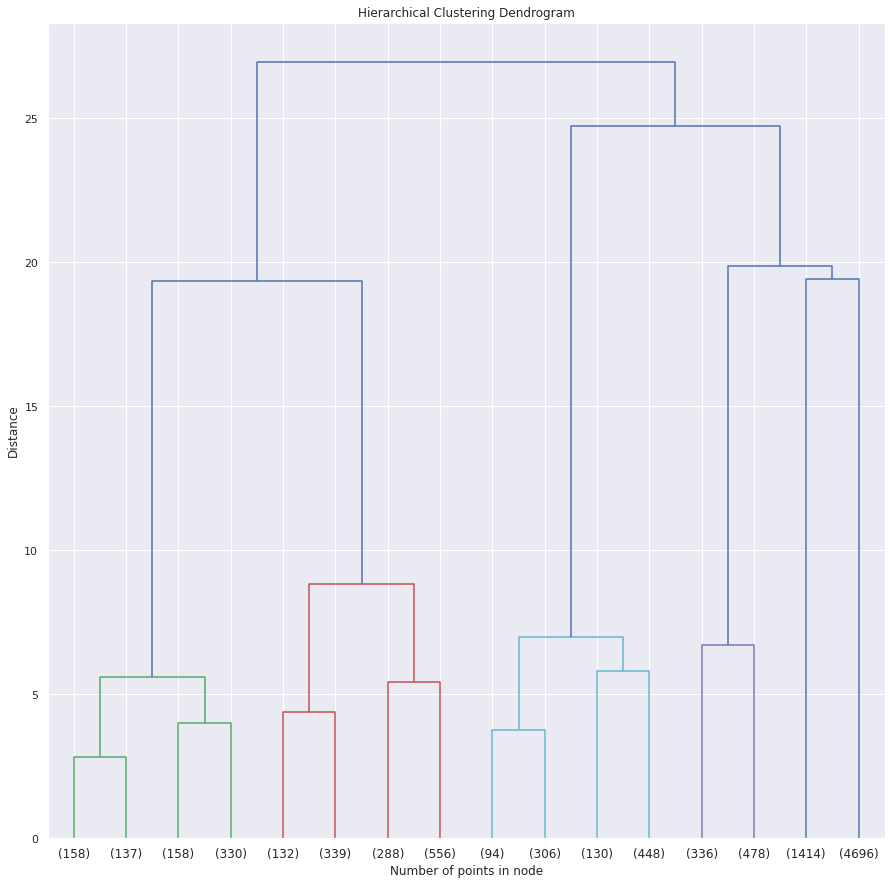

In [0]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(
    n_clusters=None,
    affinity='euclidean',
    connectivity=graph,
    linkage='ward', 
    distance_threshold=0
)
model = model.fit(X)
l = model.labels_
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")
plt.ylabel("Distance")
plt.savefig('Hierarchical clustering - ward linkage.png')
plt.show()

In [0]:
n_clusters = 6

In [0]:
model = AgglomerativeClustering(
    n_clusters=n_clusters,
    affinity='euclidean',
    connectivity=graph,
    linkage='ward'
)
model = model.fit(X)
l = model.labels_

print('Silhouette coefficient:', silhouette_score(X, l))
print('Davies-Bouldin Index:', davies_bouldin_score(X, l))

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_agglomerative.py:245: UserWarning: the number of connected components of the connectivity matrix is 33 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


Silhouette coefficient: 0.196054464853445
Davies-Bouldin Index: 1.347579822149517


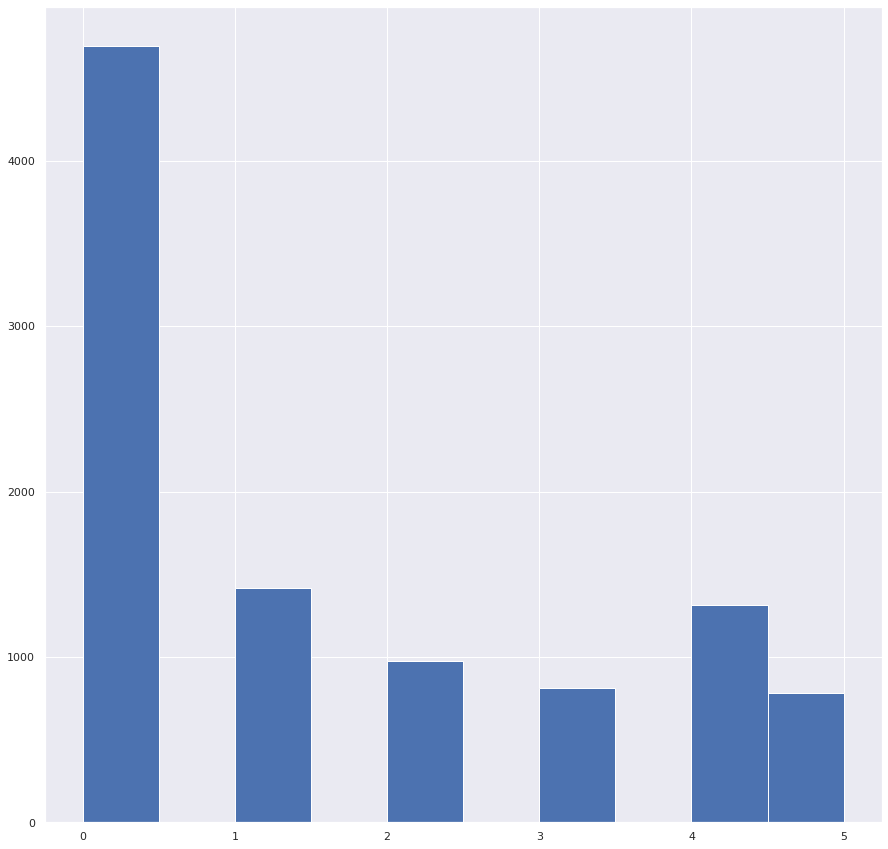

In [0]:
df['l'] = l
sns.countplot(df.l)
plt.show()

### Average

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_agglomerative.py:478: UserWarning: the number of connected components of the connectivity matrix is 49 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


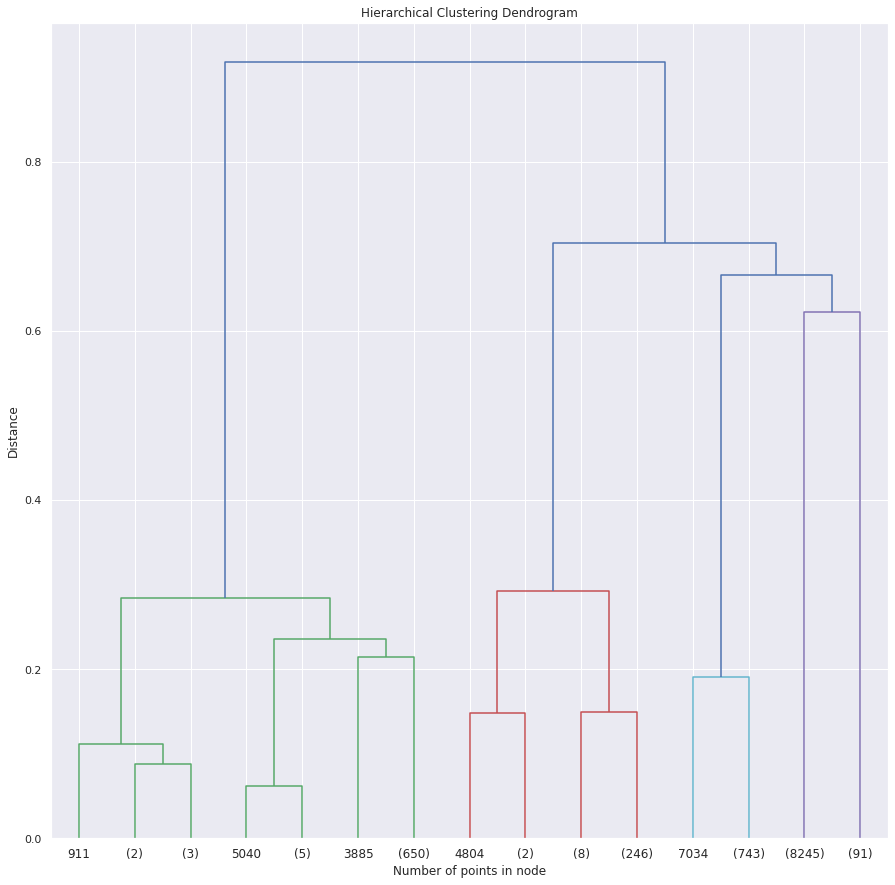

In [0]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(
    n_clusters=None,
    affinity='euclidean',
    connectivity=graph,
    linkage='average', 
    distance_threshold=0
)
model = model.fit(X)
l = model.labels_
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")
plt.ylabel("Distance")
plt.savefig('Hierarchical clustering - average linkage.png')
plt.show()

In [0]:
model = AgglomerativeClustering(
    n_clusters=5,
    affinity='euclidean',
    connectivity=graph,
    linkage='average'
)
model = model.fit(X)
l = model.labels_

print('Silhouette coefficient:', silhouette_score(X, l))
print('Davies-Bouldin Index:', davies_bouldin_score(X, l))

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_agglomerative.py:478: UserWarning: the number of connected components of the connectivity matrix is 49 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


Silhouette coefficient: 0.12881954956048985
Davies-Bouldin Index: 1.0588662201850738


In [0]:
df['l'] = l

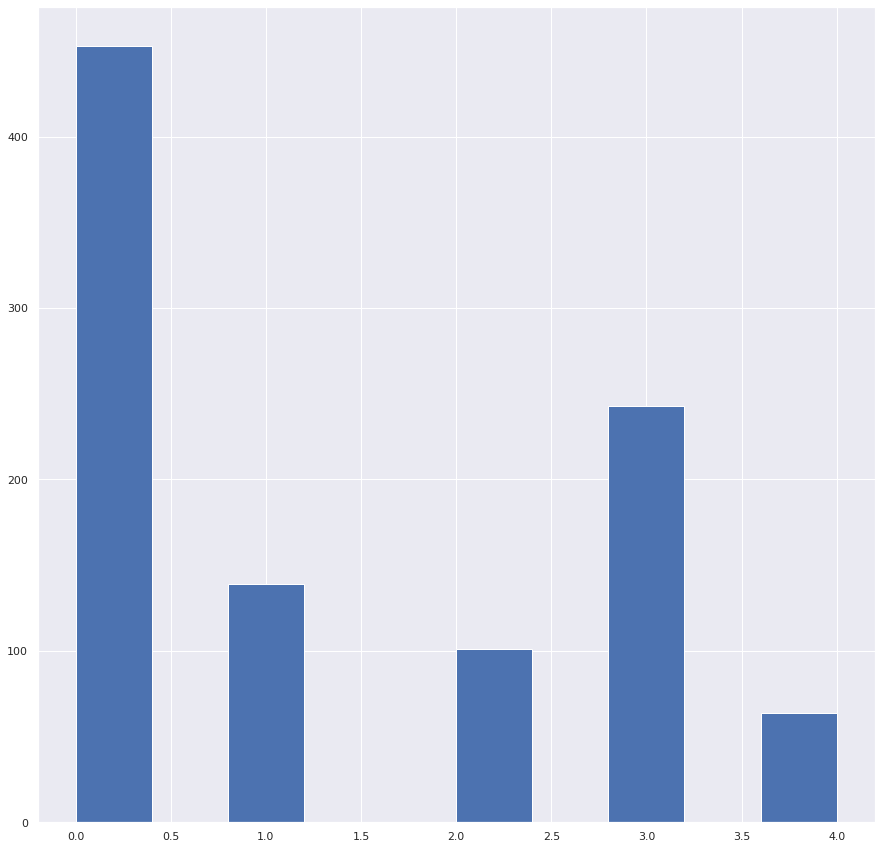

In [0]:
plt.figure(figsize=(15,10))
sns.countplot(df.l)
plt.show()

# Latent Dirichlet Allocation

Here we use LDA to do topic modelling. Topic modelling is the task of using unsupervised learning to extract the main topic that occurs in a collection of documents.  It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

- Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.

- LDA assumes that the every chunk of text we feed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial.

- It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution.

see : https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925

see (paper) : http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf

In [0]:
# here we use df, recall it is the stemmatized doc (before vectorization) with the label
# assigned by the clustering algorithm
X0 = df[df.l==0]
X1 = df[df.l==1]
X2 = df[df.l==2]
X3 = df[df.l==3]
# X4 = df[df.l==4]
# X5 = df[df.l==5]
# X6 = df[df.l==4]
# X7 = df[df.l==5]
# , X4, X5, X6, X7
X_list = [X0,X1, X2, X3]

In [0]:
n_latent_topics = 3

In [0]:
c = 0

for x in X_list:

    # get a sub dictionary of token_dictionary with only the relevant doc (from the class)
    sub_token_dictionary = {i : token_dictionary[i] for i in x.index}

    # transform the dictionary into an array (type required for the next steps)
    sub_token_list = []
    for k in sub_token_dictionary.keys():
        sub_token_list.append(sub_token_dictionary[k])

    # dictionary where the key = word and value = number of times word occurs in the entire corpus.
    dictionary = Dictionary(sub_token_list)

    # for each document we create a dictionary reporting how many words and how many times those words appear.
    bow_corpus = [dictionary.doc2bow(doc) for doc in sub_token_list]

    lda_model = LdaMulticore(
        # corpus
        corpus = bow_corpus, 
        # number of requested latent topic to be extracted
        num_topics = n_latent_topics, 
        # mapping from word ID to words
        id2word = dictionary,
        # number of passes tthrough the corpus during training                                    
        passes = 10,
        # number of workers processes to be used for parallelization
        workers = 2
    )

    print('======================================== Top '+str(n_latent_topics)+' topics for class '+str(c)+' ========================================')
    for idx, topic in lda_model.print_topics(-1):
        print("Topic: {} \nWords: {}".format(idx, topic ))
        print("\n")
    c+=1

======================================== Top 3 topics for class 0 ========================================
Topic: 0 
Words: 0.021*"protein" + 0.010*"sequence" + 0.008*"strain" + 0.008*"viral" + 0.008*"gene" + 0.007*"rna" + 0.006*"genome" + 0.005*"analysis" + 0.005*"study" + 0.005*"cell"


Topic: 1 
Words: 0.016*"rna" + 0.010*"protein" + 0.009*"viral" + 0.007*"host" + 0.007*"gene" + 0.006*"human" + 0.006*"activity" + 0.005*"antiviral" + 0.005*"replication" + 0.005*"infection"


Topic: 2 
Words: 0.011*"influenza" + 0.011*"infection" + 0.011*"respiratory" + 0.011*"viral" + 0.008*"vaccine" + 0.006*"human" + 0.006*"pcr" + 0.006*"sample" + 0.006*"detection" + 0.005*"assay"


======================================== Top 3 topics for class 1 ========================================
Topic: 0 
Words: 0.034*"cell" + 0.013*"infection" + 0.011*"response" + 0.010*"mouse" + 0.008*"antibody" + 0.007*"human" + 0.007*"immune" + 0.005*"specific" + 0.005*"disease" + 0.005*"vaccine"


Topic: 1 
Words: 0.03

In [0]:
# d = {}
# k = 0
# common_features = set()

# for x in X_list:

#     vectorizer = TfidfVectorizer(
#         # if different encoding
#         decode_error='ignore',
#         # remove accent
#         strip_accents='ascii',
#         # to lower case
#         lowercase=True,
#         # remove stopwords
#         stop_words='english',
#         # analyse at the word level
#         analyzer='word',
#         # number of features
#         max_features=10,
#         # normalize the tf-idf to make the vector have a unit norm
#         norm='l2'
#     )

#     embedding = vectorizer.fit_transform(x['text'])
#     feature_names = set(vectorizer.get_feature_names())
#     if k==0:
#         common_features = feature_names
#     else:
#         common_features = common_features.intersection(feature_names)
#     print(feature_names)
#     d[k] = feature_names
#     k+=1

- rank document according to angle with query
- probabilistic relevance feedback

# Triplet extraction

In [0]:
# ngram 
# NER
abstract = df['abstract'][0]
tokens = nltk.word_tokenize(abstract)

In [0]:
# POS tagger which uses the Penn Treebank tagset
nltk.download('averaged_perceptron_tagger')
tagged_tokens = pos_tag(token)

In [0]:

#Define your grammar using regular expressions
grammar = ('''
  NP: {<DT>?<JJ>*<NN>} # NP
      }abstract{      # Chink sequences of VBD and IN
''')
chunkParser = nltk.RegexpParser(grammar)
tree = chunkParser.parse(tagged_tokens)

In [0]:
print(tree)

In [0]:
# from biobert_embedding.embedding import BiobertEmbedding

# biobert = BiobertEmbedding()
# word_embeddings = biobert.word_vector(abstract)
# sentence_embedding = biobert.sentence_vector(abstract)

# print("Text Tokens: ", biobert.tokens)
# print ('Shape of Word Embeddings: %d x %d' % (len(word_embeddings), len(word_embeddings[0])))
# print("Shape of Sentence Embedding = ",len(sentence_embedding))


In [0]:
biobert = BiobertEmbedding()
word_embeddings = biobert.word_vector(df['abstract'][0])

In [0]:
dim = (len(word_embeddings), len(word_embeddings[0]))

In [0]:
arr = np.zeros(shape=dim)
for i in df.index:
  np.append(arr, np.array(df['abstract'][i]))
arr